### Setting PySpark Session and reading data

In [27]:
#  importing pyspark

!pip install pyspark
import pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# importing textblob for finding sentiments of tweets

!pip install textblob
from textblob import TextBlob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
# importing necessary libraries 

from pyspark.sql import SparkSession

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Building spark session

spark = SparkSession.builder.appName('proj').getOrCreate()
data = spark.read.json('/content/drive/MyDrive/DE/f4/HDFS-PySpark/final-tweet-wc.json')

In [59]:
data.schema

StructType([StructField('content', StringType(), True), StructField('date', StringType(), True), StructField('filtered', StringType(), True), StructField('lang', StringType(), True), StructField('likeCount', LongType(), True), StructField('replyCount', LongType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True), StructField('user_location', StringType(), True)])

In [60]:
data.show(5)

+--------------------+--------------------+--------------------+----+---------+----------+------------+-------------------+--------------------+--------------------+
|             content|                date|            filtered|lang|likeCount|replyCount|retweetCount|            tweetid|                 url|       user_location|
+--------------------+--------------------+--------------------+----+---------+----------+------------+-------------------+--------------------+--------------------+
|newyear with two ...|2022-01-01T00:01:...|newyear two major...|  en|       64|         2|           3|1477067523237593098|https://twitter.c...|   Casablanca, Maroc|
|drop a  if youre ...|2022-01-01T00:03:...|drop youre ready ...|  en|       73|        12|           2|1477067916193398784|https://twitter.c...|     New Mexico, USA|
|the ball is just ...|2022-01-01T00:04:...|ball ball enemy h...|  en|        0|         0|           0|1477068270620798978|https://twitter.c...|                    |
|run

# Sentiment of Tweet

In [61]:
# importing necessary libraries
from pyspark.sql.functions import udf, col

### Finding Sentiment

In [65]:
# Creating function to find sentiment value using TextBlob
def sentiment_val(tweet):
    tweet_sentiment = TextBlob(tweet)
    if tweet_sentiment.sentiment[0]>0:
        return 1 #positive
    elif tweet_sentiment.sentiment[0]<0:
        return 2 #negative
    else:
        return 0 #neutral

In [66]:
# Making sentiment_val an UDF function
sentiment_polarity = udf(lambda x: sentiment_val(x))
spark.udf.register("sentiment_polarity", sentiment_polarity)

<function __main__.<lambda>(x)>

In [67]:
data = data.withColumn('sentiment_polarity',sentiment_polarity('filtered').cast('float'))

In [68]:
data.schema

StructType([StructField('content', StringType(), True), StructField('date', StringType(), True), StructField('filtered', StringType(), True), StructField('lang', StringType(), True), StructField('likeCount', LongType(), True), StructField('replyCount', LongType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True), StructField('user_location', StringType(), True), StructField('sentiment_polarity', FloatType(), True)])

In [189]:
data.show(5)

+--------------------+--------------------+--------------------+----+---------+----------+------------+-------------------+--------------------+-----------------+------------------+
|             content|                date|            filtered|lang|likeCount|replyCount|retweetCount|            tweetid|                 url|    user_location|sentiment_polarity|
+--------------------+--------------------+--------------------+----+---------+----------+------------+-------------------+--------------------+-----------------+------------------+
|newyear with two ...|2022-01-01T00:01:...|newyear two major...|  en|       64|         2|           3|1477067523237593098|https://twitter.c...|Casablanca, Maroc|               1.0|
|drop a  if youre ...|2022-01-01T00:03:...|drop youre ready ...|  en|       73|        12|           2|1477067916193398784|https://twitter.c...|  New Mexico, USA|               1.0|
|the ball is just ...|2022-01-01T00:04:...|ball ball enemy h...|  en|        0|         0|

### Building ML models

In [70]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import Tokenizer,HashingTF, IDF
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [71]:
# Train test split
traindata, testdata = data.randomSplit([0.7,0.3])

In [72]:
# Setting name of sentiment_polarity as label
training = traindata.selectExpr("filtered as text", "sentiment_polarity as label")
training = training.withColumn("label", training["label"].cast(DoubleType()))

In [73]:
# Setting name of sentiment_polarity as label
testing = testdata.selectExpr("filtered as text", "sentiment_polarity as label")
testing = testing.withColumn("label", testing["label"].cast(DoubleType()))

In [74]:
# Tokenizing, Finding TF-IDF 
tokenizer_ = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer_.getOutputCol(), outputCol="hashing")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

In [75]:
# Creating pipeline for model stages and fiting train data in the pipeline 
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer_, hashingTF, idf, lr])
model = pipeline.fit(training)

In [76]:
# Testing model
prediction = model.transform(testing)

In [94]:
# Creating pipeline for model stages and fiting train data in the pipeline 
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
pipeline_nb = Pipeline(stages=[tokenizer_, hashingTF, idf, nb])
model_nb = pipeline_nb.fit(training)

In [95]:
# Testing model
prediction_nb = model_nb.transform(testing)

### Evaluation

In [77]:
# Accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(prediction)

0.8887912700765708

In [ ]:
y_true = prediction.select(['label']).collect()
y_pred = prediction.select(['prediction']).collect()

In [86]:
# Precision, Recall and F1-score
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90    106638
         1.0       0.91      0.89      0.90    109564
         2.0       0.81      0.81      0.81     31817

    accuracy                           0.89    248019
   macro avg       0.87      0.87      0.87    248019
weighted avg       0.89      0.89      0.89    248019



In [89]:
cnf_matrix = confusion_matrix(y_true, y_pred)

In [92]:
cnf_matrix

array([[97552,  6675,  2411],
       [ 8730, 97082,  3752],
       [ 3061,  2952, 25804]])

In [96]:
# Accuracy

evaluator_nb = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator_nb.evaluate(prediction_nb)

0.7243041358326046

In [97]:
y_true_nb = prediction_nb.select(['label']).collect()
y_pred_nb = prediction_nb.select(['prediction']).collect()

In [98]:
# Precision, Recall and F1-score
print(classification_report(y_true_nb, y_pred_nb))

              precision    recall  f1-score   support

         0.0       0.87      0.63      0.73    106638
         1.0       0.77      0.78      0.77    109564
         2.0       0.40      0.74      0.52     31817

    accuracy                           0.71    248019
   macro avg       0.68      0.72      0.68    248019
weighted avg       0.77      0.71      0.72    248019



In [129]:
cnf_matrix_nb = confusion_matrix(y_true_nb, y_pred_nb,labels=[0.0,1.0,2.0])
cnf_matrix_nb

array([[67475, 19812, 19351],
       [ 7477, 85500, 16587],
       [ 2225,  5896, 23696]])

In [130]:
from mlxtend.plotting import plot_confusion_matrix

In [131]:
from matplotlib.pyplot import plot as plt

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

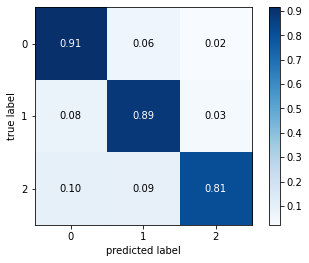

In [135]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix,colorbar=True,show_absolute=False,show_normed=True)
plt

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

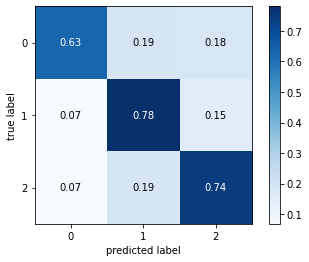

In [136]:
fig, ax = plot_confusion_matrix(conf_mat=cnf_matrix_nb,colorbar=True,show_absolute=False,show_normed=True)
plt

# Queries

### LikeCount

In [104]:
import time

In [161]:
import pandas as pd

In [105]:
data.schema

StructType([StructField('content', StringType(), True), StructField('date', StringType(), True), StructField('filtered', StringType(), True), StructField('lang', StringType(), True), StructField('likeCount', LongType(), True), StructField('replyCount', LongType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True), StructField('user_location', StringType(), True), StructField('sentiment_polarity', FloatType(), True)])

In [138]:
# Dropping unused columns
columns_to_drop = ['filtered', 'date','lang','replyCount','retweetCount','user_location','sentiment_polarity']
df_likes = data.drop(*columns_to_drop)

In [141]:
df_likes.schema

StructType([StructField('content', StringType(), True), StructField('likeCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True)])

In [142]:
# Creating rdd for likes dataframe
rdd_likes = df_likes.rdd

In [156]:
time_start = time.time()
sorted_likes_top_1 = rdd_likes.top(1, key=lambda x: x[1])
print(f"Top 1 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 1 Most Liked Tweet Query Time: 8.243618249893188


In [148]:
sorted_likes_top_1

[Row(content='i cant express my gratitude and happiness for my participation in the biggest event of all times the world cup in my country qatar with the talented jung kook  thank you for everythingworldcup worldcup jungkookxfifa jungkookatfifaworldcup', likeCount=260684, tweetid=1594415074931875848, url='https://twitter.com/FahadAlkubaisi/status/1594415074931875848')]

In [157]:
time_start = time.time()
sorted_likes_top_10 = rdd_likes.top(10, key=lambda x: x[1])
print(f"Top 10 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 10 Most Liked Tweet Query Time: 8.582376956939697


In [150]:
sorted_likes_top_10

[Row(content='i cant express my gratitude and happiness for my participation in the biggest event of all times the world cup in my country qatar with the talented jung kook  thank you for everythingworldcup worldcup jungkookxfifa jungkookatfifaworldcup', likeCount=260684, tweetid=1594415074931875848, url='https://twitter.com/FahadAlkubaisi/status/1594415074931875848'),
 Row(content='breaking karim benzema will miss the world cup confirmed he will not be part of france  man squad  worldcup', likeCount=172092, tweetid=1594096052361056256, url='https://twitter.com/FabrizioRomano/status/1594096052361056256'),
 Row(content='whos going to north korea for worldcup', likeCount=147544, tweetid=1590382569069367297, url='https://twitter.com/SimonBrodkin/status/1590382569069367297'),
 Row(content='breaking sadio man will miss the world cup senegal confirms he will not be able to be part of the squad as hes not recovering from his injury  worldcup', likeCount=117489, tweetid=1593318352927203331, ur

In [158]:
time_start = time.time()
sorted_likes_top_100 = rdd_likes.top(100, key=lambda x: x[1])
print(f"Top 100 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 100 Most Liked Tweet Query Time: 8.63142704963684


In [159]:
time_start = time.time()
sorted_likes_top_1000 = rdd_likes.top(1000, key=lambda x: x[1])
print(f"Top 1000 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 1000 Most Liked Tweet Query Time: 8.975438117980957


In [160]:
time_start = time.time()
sorted_likes_top_10000 = rdd_likes.top(10000, key=lambda x: x[1])
print(f"Top 10000 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 10000 Most Liked Tweet Query Time: 9.92312479019165


In [162]:
data_liked_tweets=pd.DataFrame(sorted_likes_top_10)
data_liked_tweets.to_csv('/content/drive/MyDrive/DE/f4/sorted_likes_top_10.csv',header=['content','likeCount','tweetid','url'])

### ReplyCount

In [170]:
# Dropping unused columns
columns_to_drop = ['filtered', 'date','lang','likeCount','retweetCount','user_location','sentiment_polarity']
df_replyCounty = data.drop(*columns_to_drop)

In [171]:
df_replyCounty.schema

StructType([StructField('content', StringType(), True), StructField('replyCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True)])

In [172]:
# Creating rdd for replycount
rdd_replyCount = df_replyCounty.rdd

In [174]:
time_start = time.time()
sorted_replyCount_top_1 = rdd_replyCount.top(1, key=lambda x: x[1])
print(f"Top 1 Most ReplyCount Tweet Query Time: {time.time() - time_start}")

Top 1 Most ReplyCount Tweet Query Time: 9.356344223022461


In [175]:
time_start = time.time()
sorted_replyCount_top_10 = rdd_replyCount.top(10, key=lambda x: x[1])
print(f"Top 10 Most ReplyCount Tweet Query Time: {time.time() - time_start}")

Top 10 Most ReplyCount Tweet Query Time: 9.19243574142456


In [176]:
time_start = time.time()
sorted_replyCount_top_100 = rdd_replyCount.top(100, key=lambda x: x[1])
print(f"Top 100 Most ReplyCount Tweet Query Time: {time.time() - time_start}")

Top 100 Most ReplyCount Tweet Query Time: 8.832696199417114


In [177]:
time_start = time.time()
sorted_replyCount_top_1000 = rdd_replyCount.top(1000, key=lambda x: x[1])
print(f"Top 1000 Most ReplyCount Tweet Query Time: {time.time() - time_start}")

Top 1000 Most ReplyCount Tweet Query Time: 9.758176803588867


In [178]:
time_start = time.time()
sorted_replyCount_top_10000 = rdd_replyCount.top(10000, key=lambda x: x[1])
print(f"Top 10000 Most ReplyCount Tweet Query Time: {time.time() - time_start}")

Top 10000 Most ReplyCount Tweet Query Time: 10.07386302947998


In [179]:
data_liked_tweets=pd.DataFrame(sorted_replyCount_top_10)
data_liked_tweets.to_csv('/content/drive/MyDrive/DE/f4/sorted_replyCount_top_10.csv',header=['content','ReplyCount','tweetid','url'])

### RetweetCount

In [180]:
# Dropping unused columns
columns_to_drop = ['filtered', 'date','lang','likeCount','replyCount','user_location','sentiment_polarity']
df_retweetCount = data.drop(*columns_to_drop)

In [181]:
df_retweetCount.schema

StructType([StructField('content', StringType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True)])

In [182]:
# Creating rdd for retweets dataframe
rdd_retweetCount = df_retweetCount.rdd

In [183]:
time_start = time.time()
sorted_retweetCount_top_1 = rdd_retweetCount.top(1, key=lambda x: x[1])
print(f"Top 1 Most retweetCount Tweet Query Time: {time.time() - time_start}")

Top 1 Most retweetCount Tweet Query Time: 12.905333757400513


In [184]:
time_start = time.time()
sorted_retweetCount_top_10 = rdd_retweetCount.top(10, key=lambda x: x[1])
print(f"Top 10 Most retweetCount Tweet Query Time: {time.time() - time_start}")

Top 10 Most retweetCount Tweet Query Time: 12.072924375534058


In [185]:
time_start = time.time()
sorted_retweetCount_top_100 = rdd_replyCount.top(100, key=lambda x: x[1])
print(f"Top 100 Most retweetCount Tweet Query Time: {time.time() - time_start}")

Top 100 Most retweetCount Tweet Query Time: 12.153854608535767


In [186]:
time_start = time.time()
sorted_retweetCount_top_1000 = rdd_retweetCount.top(1000, key=lambda x: x[1])
print(f"Top 1000 Most retweetCount Tweet Query Time: {time.time() - time_start}")

Top 1000 Most retweetCount Tweet Query Time: 10.361597061157227


In [187]:
time_start = time.time()
sorted_retweetCount_top_10000 = rdd_retweetCount.top(10000, key=lambda x: x[1])
print(f"Top 10000 Most retweetCount Tweet Query Time: {time.time() - time_start}")

Top 10000 Most retweetCount Tweet Query Time: 12.505605936050415


In [188]:
data_liked_tweets=pd.DataFrame(sorted_retweetCount_top_10)
data_liked_tweets.to_csv('/content/drive/MyDrive/DE/f4/sorted_replyCount_top_10.csv',header=['content','retweetCount','tweetid','url'])

### Month-wise sentiment counts

In [ ]:
from pyspark.sql.functions import to_timestamp,date_format

In [198]:
data.schema

StructType([StructField('content', StringType(), True), StructField('date', StringType(), True), StructField('filtered', StringType(), True), StructField('lang', StringType(), True), StructField('likeCount', LongType(), True), StructField('replyCount', LongType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True), StructField('user_location', StringType(), True), StructField('sentiment_polarity', FloatType(), True)])

In [199]:
columns_to_drop = ['content','filtered','lang','likeCount','replyCount','retweetCount','tweetid','url','user_location']
df_retweetCount = data.drop(*columns_to_drop)

In [200]:
df_retweetCount = df_retweetCount.withColumn("date",to_timestamp(col("date"))).withColumn("month", date_format(col("date"), "M"))

In [201]:
df_retweetCount.schema

StructType([StructField('date', TimestampType(), True), StructField('sentiment_polarity', FloatType(), True), StructField('month', StringType(), True)])

In [202]:
df_retweetCount = df_retweetCount.drop('date')

In [203]:
df_retweetCount

DataFrame[sentiment_polarity: float, month: string]

In [204]:
neutral_count,positive_count,negative_count,total= [],[],[],[]

In [205]:
# Finding month-wise neutral,positive,negative,total sentiment counts
for month in range(1,13):
  neutral_count.append(df_retweetCount.select("sentiment_polarity").where((df_retweetCount.sentiment_polarity==0) & (df_retweetCount.month==month)).count())
  positive_count.append(df_retweetCount.select("sentiment_polarity").where((df_retweetCount.sentiment_polarity==1) & (df_retweetCount.month==month)).count())
  negative_count.append(df_retweetCount.select("sentiment_polarity").where((df_retweetCount.sentiment_polarity==2) & (df_retweetCount.month==month)).count())
  total.append(df_retweetCount.select("sentiment_polarity").where(df_retweetCount.month==month).count())

In [206]:
neutral_count

[14558,
 14415,
 33761,
 29023,
 17280,
 26340,
 19922,
 19380,
 27170,
 38029,
 114937,
 0]

In [207]:
positive_count

[16891,
 16316,
 31043,
 29168,
 20634,
 25277,
 19540,
 21347,
 28611,
 38715,
 117215,
 0]

In [208]:
negative_count

[3833, 4024, 10675, 8261, 4227, 7141, 4220, 4201, 7371, 9991, 42285, 0]

In [209]:
total

[35282,
 34755,
 75479,
 66452,
 42141,
 58758,
 43682,
 44928,
 63152,
 86735,
 274437,
 0]

In [210]:
data_monthwise_sentiment = pd.DataFrame(list(zip(positive_count,negative_count,neutral_count,total)),index =[1,2,3,4,5,6,7,8,9,10,11,12],columns =['Positive_Sentiments', 'Negative_Sentiments','Neutral_Sentiments','Total_Sentiments'])
data_monthwise_sentiment

,Positive_Sentiments,Negative_Sentiments,Neutral_Sentiments,Total_Sentiments
1,16891,3833,14558,35282
2,16316,4024,14415,34755
3,31043,10675,33761,75479
4,29168,8261,29023,66452
5,20634,4227,17280,42141
6,25277,7141,26340,58758
7,19540,4220,19922,43682
8,21347,4201,19380,44928
9,28611,7371,27170,63152
10,38715,9991,38029,86735


In [211]:
data_monthwise_sentiment.to_csv('/content/drive/MyDrive/DE/f4/monthwise_sentiments.csv')

# Query df.top(10) on different data size

In [212]:
spark_1 = SparkSession.builder.appName('proj1').getOrCreate()
data = spark.read.json('/content/drive/MyDrive/DE/f4/tweet-wc.json')

In [215]:
data.schema

StructType([StructField('content', StringType(), True), StructField('date', StringType(), True), StructField('lang', StringType(), True), StructField('likeCount', LongType(), True), StructField('replyCount', LongType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True), StructField('user_displayname', StringType(), True), StructField('user_followersCount', LongType(), True), StructField('user_friendsCount', LongType(), True), StructField('user_id', LongType(), True), StructField('user_location', StringType(), True), StructField('user_url', StringType(), True), StructField('user_username', StringType(), True)])

In [218]:
columns_to_drop = ['filtered', 'date','lang','replyCount','retweetCount','user_location','sentiment_polarity','user_displayname','user_followersCount','user_friendsCount','user_id','user_url','user_username']
df_likes_ = data.drop(*columns_to_drop)

In [219]:
df_likes_.schema

StructType([StructField('content', StringType(), True), StructField('likeCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True)])

In [223]:
rdd_likes = df_likes_.rdd

In [224]:
time_start = time.time()
sorted_likes_top_10 = rdd_likes.top(10, key=lambda x: x[1])
print(f"Top 10 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 10 Most Liked Tweet Query Time: 3.147566556930542


In [225]:
spark_2 = SparkSession.builder.appName('proj2').getOrCreate()
data_2 = spark.read.option('multiline',True).json('/content/drive/MyDrive/DE/f4/data-analytics-tweet-wc.json')

In [227]:
data_2.schema

StructType([StructField('content', StringType(), True), StructField('date', StringType(), True), StructField('lang', StringType(), True), StructField('likeCount', LongType(), True), StructField('replyCount', LongType(), True), StructField('retweetCount', LongType(), True), StructField('tweetid', LongType(), True), StructField('url', StringType(), True), StructField('user_displayname', StringType(), True), StructField('user_followersCount', LongType(), True), StructField('user_friendsCount', LongType(), True), StructField('user_id', LongType(), True), StructField('user_location', StringType(), True), StructField('user_url', StringType(), True), StructField('user_username', StringType(), True)])

In [232]:
columns_to_drop = ['content','tweetid','url','filtered', 'date','lang','replyCount','retweetCount','user_location','sentiment_polarity','user_displayname','user_followersCount','user_friendsCount','user_id','user_url','user_username']
df_likes_ = data_2.drop(*columns_to_drop)

In [233]:
df_likes_.schema

StructType([StructField('likeCount', LongType(), True)])

In [234]:
rdd_likes = df_likes_.rdd

In [236]:
time_start = time.time()
sorted_likes_top_10 = rdd_likes.top(10)
print(f"Top 10 Most Liked Tweet Query Time: {time.time() - time_start}")

Top 10 Most Liked Tweet Query Time: 115.25807619094849
